In [1]:
# Import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Data
initialize the data transforms, image datasets, and the dataloaders. Notice, the models were pretrained with the hard-coded normalization values, as described https://pytorch.org/docs/master/torchvision/models.html
- datasets.ImageFolder导入data<br>
source：https://github.com/pytorch/vision/blob/master/torchvision/datasets/folder.py
when data are aranged as:
        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/xxz.png
        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/asd932_.png
class ImageFolder(root,transform,loader):<br>
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
     Attributes:
        classes (list): List of the class names.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
- DataLoader


In [3]:
def image_loader(path, batch_size):
    transform = transforms.Compose(
        [
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    )
    sup_train_data = datasets.ImageFolder('{}/{}/train'.format(path, 'supervised'), transform=transform)
    sup_val_data = datasets.ImageFolder('{}/{}/val'.format(path, 'supervised'), transform=transform)
    unsup_data = datasets.ImageFolder('{}/{}/'.format(path, 'unsupervised'), transform=transform)
    data_loader_sup_train = torch.utils.data.DataLoader(
        sup_train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )
    data_loader_sup_val = torch.utils.data.DataLoader(
        sup_val_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )
    data_loader_unsup = torch.utils.data.DataLoader(
        unsup_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )
    print('sup_train_data.class_to_idx==sup_val_data.class_to_idx:',sup_train_data.class_to_idx==sup_val_data.class_to_idx)
    return data_loader_sup_train, data_loader_sup_val, data_loader_unsup,sup_train_data.class_to_idx,sup_val_data.class_to_idx

In [4]:
import os
path = os.getcwd()+"/ssl_data_96"
batch_size = 64
data_loader_sup_train, data_loader_sup_val, data_loader_unsup,sup_class_to_idx_dict,val_class_to_idx_dict = image_loader(path, batch_size)


NameError: name 'input_size' is not defined

In [49]:
#batch num
print("data_loader_sup_train:",len(data_loader_sup_train))
print("data_loader_sup_val:",len(data_loader_sup_val))
print("data_loader_unsup:",len(data_loader_unsup))

data_loader_sup_train: 1000
data_loader_sup_val: 1000
data_loader_unsup: 8000


In [60]:
# build a idx to class dict for sup and val
sup_idx_to_class_dict={}
for k,v in sup_class_to_idx_dict.items():
    sup_idx_to_class_dict[v]=k
    
val_idx_to_class_dict={}
for k,v in val_class_to_idx_dict.items():
    val_idx_to_class_dict[v]=k

In [61]:
sup_idx_to_class_dict

{0: 'n00015388',
 1: 'n00288000',
 2: 'n00326094',
 3: 'n00433661',
 4: 'n00439826',
 5: 'n00440941',
 6: 'n00442847',
 7: 'n00445226',
 8: 'n00445351',
 9: 'n00445685',
 10: 'n00445802',
 11: 'n00446980',
 12: 'n00447073',
 13: 'n00447957',
 14: 'n00448126',
 15: 'n00448232',
 16: 'n00448748',
 17: 'n00448872',
 18: 'n00448958',
 19: 'n00449054',
 20: 'n00449517',
 21: 'n00449695',
 22: 'n00450700',
 23: 'n00450998',
 24: 'n00451635',
 25: 'n00453313',
 26: 'n00454237',
 27: 'n00454395',
 28: 'n00455173',
 29: 'n00466524',
 30: 'n00466712',
 31: 'n00467719',
 32: 'n00468480',
 33: 'n00470682',
 34: 'n00470966',
 35: 'n00471437',
 36: 'n00471613',
 37: 'n00475787',
 38: 'n00479076',
 39: 'n00480211',
 40: 'n00482122',
 41: 'n00483313',
 42: 'n00825773',
 43: 'n01317813',
 44: 'n01318894',
 45: 'n01321579',
 46: 'n01322604',
 47: 'n01322983',
 48: 'n01519563',
 49: 'n01528396',
 50: 'n01536334',
 51: 'n01537134',
 52: 'n01539573',
 53: 'n01540090',
 54: 'n01540233',
 55: 'n01540832',
 5

In [67]:
classes = [i for i in sup_idx_to_class_dict.values()]

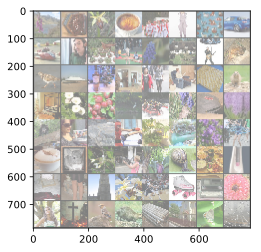

In [88]:
# functions to show an image
%config InlineBackend.figure_format = 'svg'

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()# # FloatTensor转为ndarray
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # 把channel那一维放到最后
    plt.show()
    
# get some random training images
dataiter = iter(data_loader_sup_train)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))


# 2. Training
- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
- In general both transfer learning methods follow the same few steps:1.Initialize the pretrained model
2.Reshape the final layer(s) to have the same number of outputs as the number of classes in the new dataset
3.Define for the optimization algorithm which parameters we want to update during training
4.Run the training step

In [12]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  0.4.1
Torchvision Version:  0.2.1


In [13]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 1000

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [14]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [15]:
#Set Model Parameters’ .requires_grad attribute

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## 2.1 initialize and Reshape the Networks

- difference between finetuning and feature-extraction

When feature extracting, we only want to update the parameters of the last layer, or in other words, we only want to update the parameters for the layer(s) we are reshaping. Therefore, we do not need to compute the gradients of the parameters that we are not changing, so for efficiency we set the .requires_grad attribute to False. This is important because by default, this attribute is set to True. Then, when we initialize the new layer and by default the new parameters have .requires_grad=True so only the new layer’s parameters will be updated. When we are finetuning we can leave all of the .required_grad’s set to the default of True.
<br>*inception_v3 requires the input size to be (299,299), whereas all of the other models expect (224,224).


- Resnet: https://arxiv.org/abs/1512.03385
<br>in all, have Resnet18, Resnet34, Resnet50, Resnet101, and Resnet152
<br>For Resnet18,(fc): Linear(in_features=512, out_features=1000, bias=True)

In [18]:
def initialize_model(model_name,num_classes,feature_extract,use_pretrained):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [63]:
model_name="vgg"
num_classes = 1000
num_epochs = 5

In [64]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=

# 3. Create the optimizer

In [34]:
def image_loader(path, batch_size):
    transform = transforms.Compose(
        [
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    )
    sup_train_data = datasets.ImageFolder('{}/{}/train'.format(path, 'supervised'), transform=transform)
    sup_val_data = datasets.ImageFolder('{}/{}/val'.format(path, 'supervised'), transform=transform)
    unsup_data = datasets.ImageFolder('{}/{}/'.format(path, 'unsupervised'), transform=transform)
    data_loader_sup_train = torch.utils.data.DataLoader(
        sup_train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )
    data_loader_sup_val = torch.utils.data.DataLoader(
        sup_val_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )
    data_loader_unsup = torch.utils.data.DataLoader(
        unsup_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )
    print('sup_train_data.class_to_idx==sup_val_data.class_to_idx:',sup_train_data.class_to_idx==sup_val_data.class_to_idx)
    return data_loader_sup_train, data_loader_sup_val, data_loader_unsup,sup_train_data.class_to_idx


In [23]:
import os
path = os.getcwd()+"/ssl_data_96"
batch_size = 64
data_loader_sup_train, data_loader_sup_val, data_loader_unsup,sup_class_to_idx_dict,val_class_to_idx_dict = image_loader(path, batch_size)

sup_train_data.class_to_idx==sup_val_data.class_to_idx: True


In [24]:
dataloaders={}
dataloaders['train'],dataloaders['val']=data_loader_sup_train, data_loader_sup_val

In [25]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


# 4. Run Training and Validation Step


In [32]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/4
----------
train Loss: 6.6241 Acc: 0.0201
val Loss: 6.1425 Acc: 0.0666

Epoch 1/4
----------
train Loss: 5.7739 Acc: 0.1220
val Loss: 5.3784 Acc: 0.1723

Epoch 2/4
----------
train Loss: 5.0791 Acc: 0.2185
val Loss: 4.7774 Acc: 0.2390

Epoch 3/4
----------
train Loss: 4.5296 Acc: 0.2864
val Loss: 4.3228 Acc: 0.2863

Epoch 4/4
----------


KeyboardInterrupt: 

## data augmentation

In [61]:
def show_dataset(dataset, n=6):
  img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(len(dataset))))
  plt.imshow(img)
  plt.axis('off')

In [62]:
show_dataset(data_loader_sup_train)

TypeError: 'DataLoader' object does not support indexing

In [59]:
data_loader_sup_train.size()

AttributeError: 'DataLoader' object has no attribute 'size'